# Importance sampling: toy example batch sampling
In this method we sample from a batch instead of one by one

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch'''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2):
    '''Makes a random image batch of size (batch_size, height, width, channels) 
    with black to white ratio of value ratio
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])]
    image_batch = torch.zeros(size) + offset # to make light gray
    image_batch[idx] = 1 - offset # to make dark gray 
    return image_batch

### The dataset class

In [4]:
class BlackWhiteDataset(Dataset):
    '''The dataloader for the black and white images'''
    def __init__(self, offset=0.2, ratio=0.5):
        self.offset = offset
        self.ratio = ratio
        self.dataset = random_image_data(ratio = self.ratio, 
                                         offset = self.offset)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0] += self.offset # light grey
        example_imgs[1] = 1 - self.offset # dark grey
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

#### Example
Here we see what the simple black-and-white dataset consist of. The images are pixels of spatial size $1 \times 1$. The offset indicates the brightness of the pixels and the ratio determines how often they are represented in the dataset.

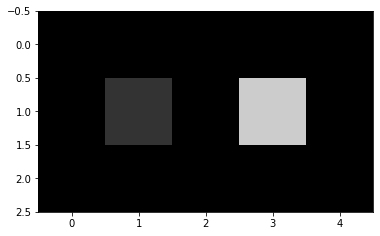

In [5]:
# Sample
offset = 0.2
ratio = 0.5
dataset = BlackWhiteDataset(offset=offset, ratio=ratio)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

visualize_img_batch(dataset.example_imgs)

### The weight network

In [6]:
class WeightNet(nn.Module):
    '''A simple neural network that returns importances'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.softmax(self.fc2(h1))
        return out

### The training loop

In [7]:
weight_network = WeightNet()
optimizer_w = optim.Adam(weight_network.parameters(), lr=0.01)

offset = 0.4 # Offset from black and white, to make grey (to make probablities nuanced)
dataset = BlackWhiteDataset(offset=offset)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
sampled_batch_size = 64

example_img = torch.cat((torch.Tensor([offset, offset, offset]), 
                         torch.Tensor([1-offset, 1-offset, 1-offset])))
losses = []
example_importances = []
example_discriminations = []
for i, data in enumerate(dataloader):
    optimizer_w.zero_grad()
    
    importances = weight_network(data).squeeze() # Get the importances for each image
    sampled_idx = list( # Sample according to these importances
        torch.utils.data.sampler.WeightedRandomSampler(importances,
                                                       sampled_batch_size, 
                                                       replacement=False)
    )
    sampled_importances = importances[sampled_idx] # The importances assigned to the smaller batch
    sampled_batch = data[sampled_idx] # The sampled smaller batch
    
    # The loss function:
    loss = (sampled_batch.mean(1).view(-1, 1) * (sampled_importances/
                                        sampled_importances.detach()).view(-1, 1)).mean()

    loss.backward()
    optimizer_w.step()

    losses += [loss.item()] # Store loss in a list
    w = weight_network(example_img)
    example_importances += [(w[0].item(), w[1].item())] # Store examples in a list
    
    # print statistics
    if i % 500 == 0:
        print('step', i, 'loss: ', loss.item())

step 0 loss:  0.512499988079071
step 500 loss:  0.40312501788139343
step 1000 loss:  0.40000003576278687
step 1500 loss:  0.40000003576278687
step 2000 loss:  0.40000003576278687
step 2500 loss:  0.40000003576278687
step 3000 loss:  0.40000003576278687
step 3500 loss:  0.40000003576278687
step 4000 loss:  0.40000003576278687
step 4500 loss:  0.40000003576278687
step 5000 loss:  0.40000003576278687
step 5500 loss:  0.40000003576278687
step 6000 loss:  0.40000003576278687
step 6500 loss:  0.4031250476837158
step 7000 loss:  0.40000003576278687
step 7500 loss:  0.40000003576278687
step 8000 loss:  0.40000003576278687


In [8]:
def amplify_visual(sampled_batch, offset=0.2):
    ''' Sometimes the difference in shade can be non-visible to the eye.
        This function makes the contrast between the two shades bigger. '''
    sampled_batch[sampled_batch < 0.5] = offset
    sampled_batch[sampled_batch > 0.5] = 1-offset
    return sampled_batch

### Interpretation
As we can see in the following results: the importance assigned to the dark image is approaching 1 and the light image is approaching 0. This is because the loss function is minimizing the mean of the sampled images, hence darker images (<0.5).

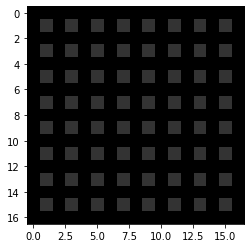

light grey = 0.4, dark grey = 0.6


In [9]:
visualize_img_batch(amplify_visual(sampled_batch))
print('light grey = {}, dark grey = {}'.format(1-offset, offset))

The loss is converging towards the mean value of the darkest image, as this is the global minimum of our objective function.

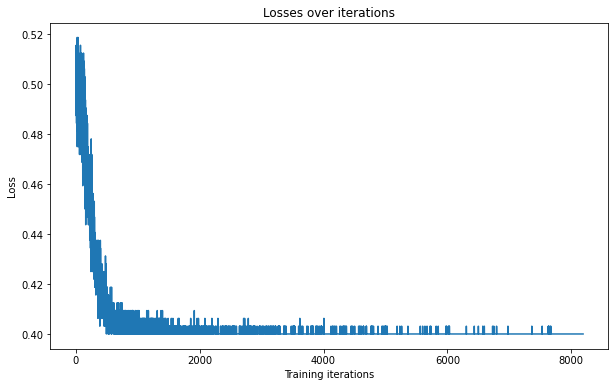

In [10]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

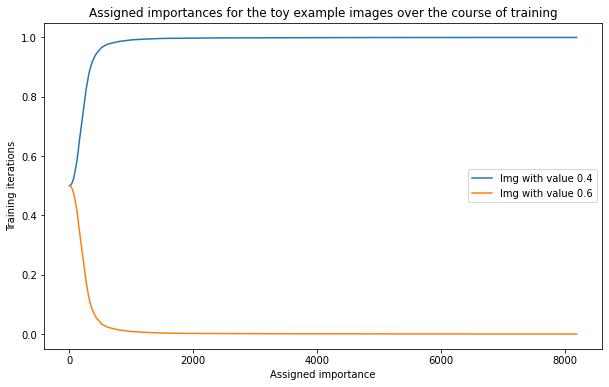

In [11]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances)
plt.legend(['Img with value {}'.format(offset), 'Img with value {}'.format(1-offset)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()